# Iteration 9: ASU occupancy plot

## Plain English Summary

A key output in the paper is an occupancy chart: a bar chart of the occupancy relative frequency on each day the model is run.

To do this we create functions to 

1. Calculate relative, and cumulative frequencies (the latter will be used for the blocking calculation)
2. Generate a step plot.

For the latter we ask the LLM to use matplotlibs step plot type

## Notebook imports

In [1]:
from IPython.display import Markdown, display
import math
import statistics
from sim_tools.distributions import Lognormal

## LLM Prompt

In [2]:
display(Markdown("inputs/09_iteration.md"))

create a function in python called `calculate_occupancy_frequencies` that accepts a python list of integer values. The function should use numpy to calculate the relative and cumulative frequencies of the numbers. The function should return a tuple containing the relative frequency, cumulative frequency, and the unique values.  

The relative frequency, unique values, a string called "x_label" (default value = "No. people in ASU"), and figure size (default = (12, 5)) should be passed to a function called `occupancy_plot` that creates a matplotlib bar chart of the relative frequency.  the x axis values are taken from the unique values parameter. The x axis ticks should run from 0 to 30 and all values should be displayed.  the x axis is label is set to the value of "x_label" The function `occupancy_plot` returns the matplotlib figure and axis objects to the calling code.  

The output should display the full script for creating a default `Experiment` and running the simulation model. Modify the script as follows: After the simulation model experiment is complete the code should call `calculate_occupancy_frequencies` and pass the "asu_occupancy" list as a parameter.  The code should then use `occupancy_plot` and show the returned plot.



## Date and time of input to LLM

> 1330 7th March 2024

## Observations on the LLM Output

* The two functions are simple and appear to be correct. The prompt did not ask for any sizing of plot.


## Sources reported by the LLM (reported with prompt b)

* None reported at time of generation.

## Code carried over from iteration 8

We carry over:

* `normal_moments_from_lognormal` - a function for converting moments of a lognormal to underlying normal
* `AcuteStrokeUnit` - acute ward logic
* `Experiment` - containers class for model functions
*  `audit_acute_occupancy` - code to observe the ASU occupancy at specified time intervals.

In [3]:
import simpy
import numpy as np

# External function to convert Lognormal moments to Normal moments
def normal_moments_from_lognormal(mean, std_dev):
    phi = np.sqrt(std_dev ** 2 + mean ** 2)
    mu = np.log(mean ** 2 / np.sqrt(std_dev ** 2 + mean ** 2))
    sigma = np.sqrt(np.log(phi ** 2 / mean ** 2))
    return mu, sigma

In [4]:
# Define the AcuteStrokeUnit class with occupancy tracking and event tracing based on Experiment settings
class AcuteStrokeUnit:
    def __init__(self, env, experiment):
        self.env = env
        self.experiment = experiment
        self.patient_count = 0
        self.occupancy = 0

    def stroke_acute_treatment(self, patient_type):
        if patient_type == "Rehab":
            mu, sigma = normal_moments_from_lognormal(self.experiment.rehab_mean, self.experiment.rehab_std_dev)
            length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        elif patient_type == "ESD":
            mu, sigma = normal_moments_from_lognormal(self.experiment.esd_mean, self.experiment.esd_std_dev)
            length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        else:
            mu, sigma = normal_moments_from_lognormal(self.experiment.other_dest_mean, self.experiment.other_dest_std_dev)
            length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"Stroke patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment

    def tia_acute_treatment(self):
        mu, sigma = normal_moments_from_lognormal(self.experiment.tia_dest_mean, self.experiment.tia_dest_std_dev)
        length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"TIA patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment

    def neuro_acute_treatment(self):
        mu, sigma = normal_moments_from_lognormal(self.experiment.neuro_dest_mean, self.experiment.neuro_dest_std_dev)
        length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"Complex Neuro patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment

    def other_acute_treatment(self):
        mu, sigma = normal_moments_from_lognormal(self.experiment.other_dest_mean_2, self.experiment.other_dest_std_dev_2)
        length_of_stay = np.random.lognormal(mean=mu, sigma=sigma)
        
        self.occupancy += 1  # Increment occupancy when a patient arrives
        yield self.env.timeout(length_of_stay)
        if self.experiment.trace:
            print(f"Other patient {self.patient_count} finished treatment at {self.env.now} days")
        self.occupancy -= 1  # Decrement occupancy at the end of treatment

    def stroke_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.stroke_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            post_asu_destination = np.random.choice(["Rehab", "ESD", "Other"], p=[0.24, 0.13, 0.63])
            if self.experiment.trace:
                print(f"Stroke patient {self.patient_count} arrived at {self.env.now} days and will go to {post_asu_destination}")
            self.env.process(self.stroke_acute_treatment(post_asu_destination))

    def tia_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.tia_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            if self.experiment.trace:
                print(f"TIA patient {self.patient_count} arrived at {self.env.now} days")
            self.env.process(self.tia_acute_treatment())

    def neuro_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.neuro_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            if self.experiment.trace:
                print(f"Complex Neuro patient {self.patient_count} arrived at {self.env.now} days")
            self.env.process(self.neuro_acute_treatment())

    def other_patient_generator(self):
        while True:
            interarrival_time = np.random.exponential(self.experiment.other_interarrival_mean)
            yield self.env.timeout(interarrival_time)
            self.patient_count += 1
            if self.experiment.trace:
                print(f"Other patient {self.patient_count} arrived at {self.env.now} days")
            self.env.process(self.other_acute_treatment())


In [5]:
# Define the Experiment class to store model parameters and occupancy data
class Experiment:
    def __init__(self, stroke_mean=1.2, tia_mean=9.3, neuro_mean=3.6, other_mean=3.2,
                 rehab_mean=7.4, rehab_std_dev=8.6, esd_mean=4.6, esd_std_dev=4.8,
                 other_dest_mean=7.0, other_dest_std_dev=8.7,
                 tia_dest_mean=1.8, tia_dest_std_dev=5.0,
                 neuro_dest_mean=4.0, neuro_dest_std_dev=5.0,
                 other_dest_mean_2=3.8, other_dest_std_dev_2=5.2,
                 run_length=1825, trace=False):
        self.stroke_interarrival_mean = stroke_mean
        self.tia_interarrival_mean = tia_mean
        self.neuro_interarrival_mean = neuro_mean
        self.other_interarrival_mean = other_mean
        self.rehab_mean = rehab_mean
        self.rehab_std_dev = rehab_std_dev
        self.esd_mean = esd_mean
        self.esd_std_dev = esd_std_dev
        self.other_dest_mean = other_dest_mean
        self.other_dest_std_dev = other_dest_std_dev
        self.tia_dest_mean = tia_dest_mean
        self.tia_dest_std_dev = tia_dest_std_dev
        self.neuro_dest_mean = neuro_dest_mean
        self.neuro_dest_std_dev = neuro_dest_std_dev
        self.other_dest_mean_2 = other_dest_mean_2
        self.other_dest_std_dev_2 = other_dest_std_dev_2
        self.run_length = run_length
        self.trace = trace
        self.asu_occupancy = []  # List to store ASU occupancy data

# Define the audit_acute_occupancy generator function to record ASU occupancy at intervals
def audit_acute_occupancy(acute_audit_interval, asu, experiment):
    while True:
        yield asu.env.timeout(acute_audit_interval)
        experiment.asu_occupancy.append(asu.occupancy)




## LLM output

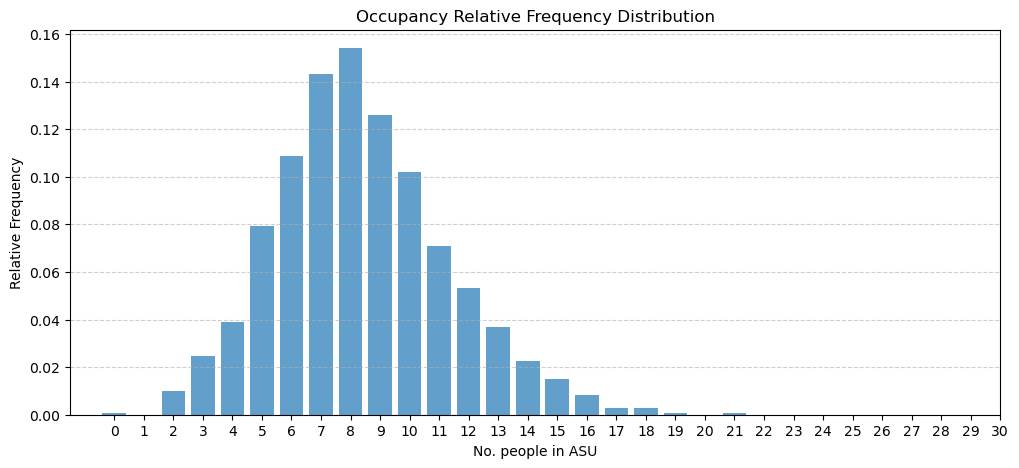

(<Figure size 1200x500 with 1 Axes>,
 <Axes: title={'center': 'Occupancy Relative Frequency Distribution'}, xlabel='No. people in ASU', ylabel='Relative Frequency'>)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_occupancy_frequencies(data):
    unique_values, counts = np.unique(data, return_counts=True)
    relative_frequency = counts / len(data)
    cumulative_frequency = np.cumsum(relative_frequency)
    return relative_frequency, cumulative_frequency, unique_values

def occupancy_plot(relative_frequency, unique_values, x_label="No. people in ASU", fig_size=(12, 5)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.bar(unique_values, relative_frequency, align='center', alpha=0.7)
    ax.set_xticks(np.arange(0, 31, 1))
    ax.set_xlabel(x_label)
    ax.set_ylabel('Relative Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.title('Occupancy Relative Frequency Distribution')
    plt.show()
    return fig, ax

# Create an instance of the Experiment class with default parameters and trace set to False
default_experiment_params = Experiment()

# Create the simulation environment and AcuteStrokeUnit instance with the Experiment parameters
env = simpy.Environment()
acu_experiment = AcuteStrokeUnit(env, default_experiment_params)

# Start the patient generators for each type of patient in the AcuteStrokeUnit instance
env.process(acu_experiment.stroke_patient_generator())
env.process(acu_experiment.tia_patient_generator())
env.process(acu_experiment.neuro_patient_generator())
env.process(acu_experiment.other_patient_generator())

# Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
env.process(audit_acute_occupancy(1, acu_experiment, default_experiment_params))

# Run the simulation until the specified run length in the Experiment parameters
env.run(until=default_experiment_params.run_length)

# Calculate occupancy frequencies and plot the relative frequency distribution
relative_freq, _, unique_vals = calculate_occupancy_frequencies(default_experiment_params.asu_occupancy)
occupancy_plot(relative_freq, unique_vals)


In [7]:
# added by tester
print(f'{len(default_experiment_params.asu_occupancy)=}')
print(f'{env.now=}')

len(default_experiment_params.asu_occupancy)=1824
env.now=1825


## Testing
* **Results processing 1**: code correctly calculates relative and cumulative frequencies
    * Expected result: for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
    * Actual result (PASS): for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
* **Results collection test 1**: Test the result collection process for ASU collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 2**: Test ASU ward occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range in the range 0 to 50 with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are in the range in the range 0 to 50 with sensible moments.
* **Suppress simulated trace**: Test that setting experiment.trace = False suppresses output by default.
    * Expected result: The model runs with no simulated log output
    * Actual result (PASS): The model runs with no simulated log output
* **Testing lognormal function**: Test that lognomal function correctly calculates the moments of the underlying normal dist.
    * Expected result: The LLM generated function and `sim-tools.distributions.Lognormal` perform the same conversion.
    * Actual results (PASS):  The functions generate the same values.
* **Extreme value test 1**: TIA, Complex Neuro, Other, have their inter-arrival time set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the model is "Accident and Emergency."
* **Extreme value test 2**: All patient types have have their inter-arrival time set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Different run length**: The run length of the model is set to 10 days.
    * Expected result: The model should runs no longer than 10 simulated time periods
    * Actual result (PASS): The model runs no longer than 10 simulated time periods
* **Extreme value test 3**: All patient types have have their mean length of stay time set to $M$ a very large number
    * Expected result: No patients depart the model (only arrivals seen in log)
    * Actual Results (PASS): No patients depart the model.
* **Extreme value test 4**: All patient types apart from stroke->rehab have have their mean length of stay time set to $M$ a very large number
    * Expected result: Only stroke patients depart the model (seen in log)
    * Actual Results (PASS): Only stroke patient depart the model.

## Results processing 1

Test that the code correctly calculates the relative and cumulative frequencies of a python list of integer values.

(PASS)

In [8]:
def result_processing_test_1(values, rel_expected, cum_expected):
    '''
    Test the `calculate_occupancy_frequencies` function works
    as expected.

    Expected result: relative frequencies and cumulative freqs
    are the same as expected values.

    Params:
    ------
    values: list
        list of values to test

    rel_expected: list
        list of floats - expected relative freqs

    cum_expected: list
        list of floats - expected cumulative freqs

    Returns:
    -------
    bool: does the model pass the test.
    '''
    rel, cum, unique = calculate_occupancy_frequencies(values)
    # use all close to allow for minor floating point differences.
    return (set(rel) == set(rel_expected)) and  np.allclose(np.array(cum_expected), cum)

In [9]:
result_processing_test_1(values=[1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
                         rel_expected=[0.4, 0.3, 0.2, 0.1],
                         cum_expected=[0.4, 0.7, 0.9, 1.0])

True

## Results collection test 1

Test the optional results collection process works correctly.  The process should collect acute stroke occupancy every day

(PASS)

In [10]:
def results_collection_test1(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: len(experiment.occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment()

    acu_experiment = AcuteStrokeUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    env.process(audit_acute_occupancy(audit_interval, acu_experiment, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.run_length)

    print(f'{len(default_experiment_params.asu_occupancy)=}')
    print(f'{env.now=}')
    return len(default_experiment_params.asu_occupancy) == (env.now - 1)

In [11]:
results_collection_test1()

len(default_experiment_params.asu_occupancy)=1824
env.now=1825


True

## Result collection test 2

In [12]:
def results_collection_test2(audit_interval=1):
    '''
    Test ASU ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 0 to 50 with sensible moments.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment()

    acu_experiment = AcuteStrokeUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())

    # optional results collection
    # Start the audit_acute_occupancy generator function to record ASU occupancy at intervals
    env.process(audit_acute_occupancy(audit_interval, acu_experiment, default_experiment_params))
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.run_length)

    print(f'{min(default_experiment_params.asu_occupancy)=}')
    print(f'{max(default_experiment_params.asu_occupancy)=}')
    print(f'{statistics.fmean(default_experiment_params.asu_occupancy)=}')
    print([round(q, 1) for q in statistics.quantiles(default_experiment_params.asu_occupancy, n=10)])

In [13]:
results_collection_test2()

min(default_experiment_params.asu_occupancy)=0
max(default_experiment_params.asu_occupancy)=21
statistics.fmean(default_experiment_params.asu_occupancy)=8.151315789473685
[4.5, 6.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


## Test suppress trace

(PASS)

In [14]:
def test_suppress_log(trace):
    '''
    Test that setting experiment.trace 
    False suppresses output.

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arr~ival rates
    default_experiment_params = Experiment(
        trace=trace,
    )

    acu_experiment = AcuteStrokeUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.run_length)

    return acu_experiment.patient_count

In [15]:
test_suppress_log(trace=False)

2715

### Lognormal test

Test that lognomal function correctly calculates the moments of the underlying normal dist.

**Result: PASS**

In [16]:
def test_lognormal_moments(mean, std):
    '''
    Test that lognomal function correctly calculates 
    the moments of the underlying normal dist.

    Params:
    ------
    mean: float
        mean of the lognormal distribution

    std: float
        st dev of the lognormal distribution

    Returns:
    -------
    bool
    '''
   
    # Lognormal class from sim-tools.
    expected_moments = Lognormal(mean, std)
    print(expected_moments.mu, expected_moments.sigma)
    
    ## llm code
    llm_mu, llm_sigma = normal_moments_from_lognormal(mean, std)
    print(llm_mu, llm_sigma)
    
    return (llm_mu, llm_sigma) == (expected_moments.mu, expected_moments.sigma)

In [17]:
test_lognormal_moments(128.79, 267.51)

4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718


True

### Extreme value test 1

The model uses hard coded parameters.  The most simple way to modify the code for this test was to change hard coded parameters for $M$

**Result: PASS**

In [18]:
M = 10_000_000

In [19]:
def ev_test_1(large_number):
    '''
    TIA, Complex Neuro, Other, have their inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the model 
    is "Stroke". This is seen in the event log

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        trace=True,
    )

    acu_experiment = AcuteStrokeUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.run_length)

    return acu_experiment.patient_count

In [20]:
ev_test_1(M)

Stroke patient 1 arrived at 2.6049010563415345 days and will go to Other
Stroke patient 2 arrived at 2.718685834497276 days and will go to ESD
Stroke patient 2 finished treatment at 3.819889302314694 days
Stroke patient 3 arrived at 4.723548064349929 days and will go to Other
Stroke patient 3 finished treatment at 5.597845452380691 days
Stroke patient 4 arrived at 5.647672586077259 days and will go to Other
Stroke patient 5 arrived at 5.733170002631693 days and will go to Rehab
Stroke patient 6 arrived at 6.549268750071745 days and will go to Other
Stroke patient 7 arrived at 6.549748609075896 days and will go to Other
Stroke patient 7 finished treatment at 7.469146887686906 days
Stroke patient 8 arrived at 8.299012142731447 days and will go to Rehab
Stroke patient 8 finished treatment at 8.91895397820204 days
Stroke patient 8 finished treatment at 9.34862494253791 days
Stroke patient 8 finished treatment at 9.479763638704886 days
Stroke patient 9 arrived at 9.562019583466697 days and 

1488

### Extreme value test 2

* An experiment is setup so that all patient types have a mean inter-arrival rate of $M$

**Result: PASS**

In [21]:
def ev_test_2(large_number):
    '''
    All patient types have have their inter-arrival time is 
    set to $M$ a very large number
    
    Expected result: No patients arrive to the model.
    
    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        stroke_mean=large_number,
        tia_mean=large_number,
        neuro_mean=large_number,
        other_mean=large_number,
        trace=False,
    )

    acu_experiment = AcuteStrokeUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.run_length)

    return acu_experiment.patient_count

In [22]:
ev_test_2(M)

0

### Different run length test

The model has again been modified to use the original code and parameters generated by the LLM.

In [23]:
TEN_DAYS = 10

In [24]:
def test_run_length(run_length):
    '''
    Test that the run length of the model can be modified.
    
    Expected result: The model should runs no longer than the new run length.

    Params:
    ------
    run_length: float
        Run length of the model in days.

    Returns:
    -------
    float
        Simulation end time.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        run_length=run_length,
        trace=False,
    )

    acu_experiment = AcuteStrokeUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.run_length)

    return env.now

In [25]:
test_run_length(TEN_DAYS)

10

### Extreme value test 3

* An experiment is setup so that all patient types have a mean length of stay on the ASU of $M$

**Result: PASS**

In [26]:
def ev_test_3(large_number):
    '''
    All patient types have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: No patients depart the model 
    The number of arrivals = the occupancy of the model.

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_mean=M,  # stroke->rehab
        esd_mean=M,    # stroke-> ESD
        other_dest_mean=M, # stroke->other
        tia_dest_mean=M,   # TIA patients
        neuro_dest_mean=M, # complex neuro patients
        other_dest_mean_2=M, # other (med outlier) patients
        trace=False,
    )

    acu_experiment = AcuteStrokeUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.run_length)

    print(f'{acu_experiment.patient_count=}')
    print(f'{acu_experiment.occupancy=}')
    
    return acu_experiment.patient_count == acu_experiment.occupancy

In [27]:
result = ev_test_3(M)

acu_experiment.patient_count=2773
acu_experiment.occupancy=2773


In [28]:
result

True

### Extreme value test 4

* An experiment is setup so that all patient types other than stroke->rehab have a mean length of stay on the ASU of $M$

**Result: PASS**

In [29]:
def ev_test_4(large_number):
    '''
    All patient types apart from stroke-rehab patients
    have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: Only stroke patients depart the
    model.
    (assed by viewing  log and patient_count > occupancy)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Initialize the Acute Stroke Unit model#
    # set ASU arrival rates
    default_experiment_params = Experiment(
        rehab_mean=7.4,  # stroke->rehab
        esd_mean=M,    # stroke-> ESD
        other_dest_mean=M, # stroke->other
        tia_dest_mean=M,   # TIA patients
        neuro_dest_mean=M, # complex neuro patients
        other_dest_mean_2=M, # other (med outlier) patients
        trace=False,
    )

    acu_experiment = AcuteStrokeUnit(env, default_experiment_params)
    
    # Start the patient generators for each type of patient
    env.process(acu_experiment.stroke_patient_generator())
    env.process(acu_experiment.tia_patient_generator())
    env.process(acu_experiment.neuro_patient_generator())
    env.process(acu_experiment.other_patient_generator())
    
    # Run the simulation until the specified run length in the Experiment parameters
    env.run(until=default_experiment_params.run_length)

    print(f'{acu_experiment.patient_count=}')
    print(f'{acu_experiment.occupancy=}')
    
    return acu_experiment.patient_count > acu_experiment.occupancy

In [30]:
results = ev_test_4(M)

acu_experiment.patient_count=2785
acu_experiment.occupancy=2442


In [31]:
results

True